<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/Dataset_Gigante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comprobando un dataset gigante de música anotada
- https://repository.cloudlab.zhaw.ch/artifactory/deepscores/archives/2017/
- https://tuggeluk.github.io/class_names/class_names.csv
- https://tuggeluk.github.io/class_names/class_names_extended.csv

## Librerías y dataset

In [1]:
import xml.etree.ElementTree as ET

In [2]:
%%capture
!pip install icevision[all]

In [3]:
from icevision.all import *
import cv2

In [4]:
%%capture
!wget https://repository.cloudlab.zhaw.ch/artifactory/deepscores/archives/2017/DeepScores2017_archive0.zip
!unzip DeepScores2017_archive0.zip

## XML $\rightarrow$ JSON

In [5]:
import json

In [6]:
def xml2json(path):
  tree = ET.parse(path)
  root = tree.getroot()
  json = []
  o = Path(path)
  o=o.stem+'.xml'
  o = '/content/images_png/'+o[:o.find('.xml')]+'.png'
  img = cv2.imread(o)
  for object in root.iter("object"):
      label = object.find("name").text
      xml_bbox = object.find("bndbox")
      xmin = int(float(xml_bbox.find("xmin").text)*img.shape[1])
      ymin = int(float(xml_bbox.find("ymin").text)*img.shape[0])
      xmax = int(float(xml_bbox.find("xmax").text)*img.shape[1])
      ymax = int(float(xml_bbox.find("ymax").text)*img.shape[0])
      json.append({"box": [xmin, ymin, xmax, ymax],"label": label})
  return json

In [ ]:
path=Path('/content/xml_annotations')
print(len(path.ls()))
k = 0
for p in path.ls():
  if k%100 == 0: print(k)
  k = k + 1
  j = xml2json(str(p))
  o = p.stem+'.xml'
  o = '/content/json_annotations/'+o[:o.find('.xml')]+'.json'  
  with open(o,'w') as f:
    json.dump(j,f)

## Parser

In [8]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv('/content/class_names_extended.csv',names = [0,1])

In [10]:
class_map = ClassMap(list(np.array(df[1])))

In [11]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [12]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [13]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          if fichero.name!='.ipynb_checkpoints':
            yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.png")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.png")

    def labels(self, o) -> List[int]:
      d={df[1][i]:df[0][i] for i in range(0,len(df))}
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for L in anotacion:
        label.append(d[L['label']])
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for L in anotacion:
        bbox.append(BBox.from_xyxy(L['box'][0],L['box'][1],L['box'][2],L['box'][3]))
      return bbox

In [14]:
anot=AnotacionParser('/content/images_png','/content/json_annotations')

In [15]:
%%capture
train_rs, valid_rs = anot.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:126


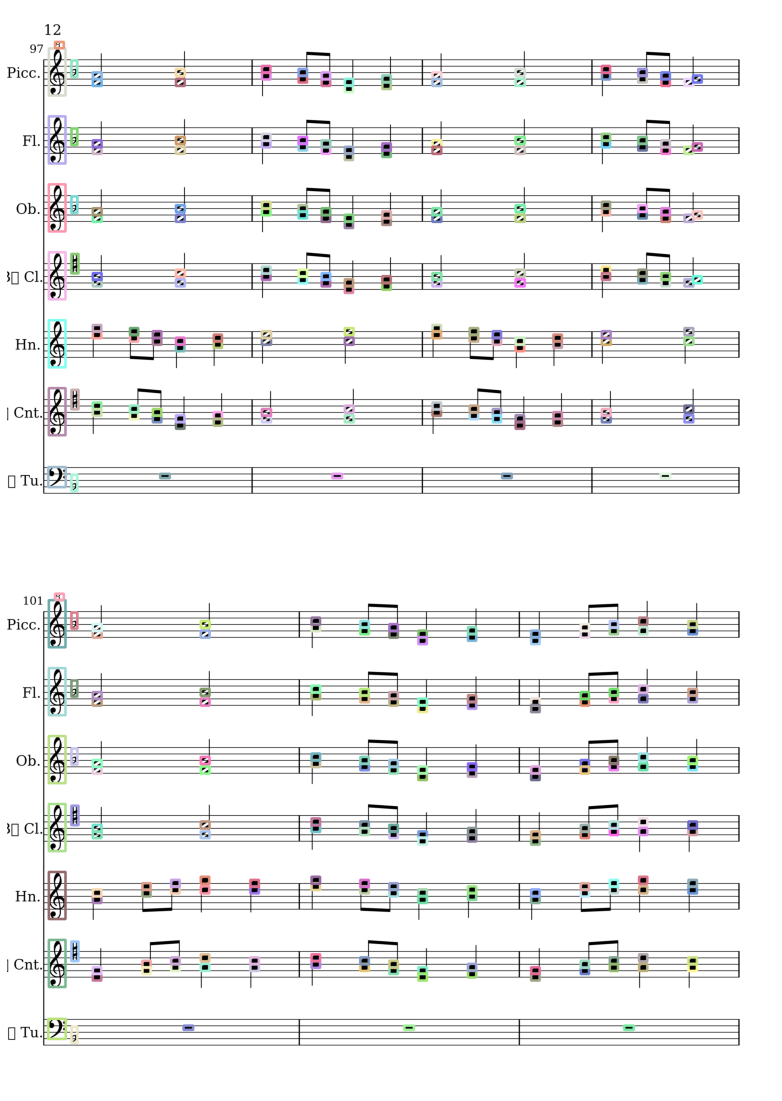

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15, 20))
show_record(train_rs[2], display_label=False,ax=ax)

## Entrenando a ver que pasa

In [17]:
class EarlyStoppingMAP(fastai.EarlyStoppingCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=5, reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and maybe stop training."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False


    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        print(f'No improvement since epoch {self.epoch-self.wait}: early stopping')
        raise fastai.CancelFitException()

class SaveModelMAP(fastai.SaveModelCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, with_opt=False,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, fname=fname,every_epoch=every_epoch, with_opt=with_opt,
                     reset_on_fit=reset_on_fit)

  def _save(self, name):
    super()._save(name)

  def after_epoch(self):
    "Compare the value monitored to its best score and save if best."
    if self.every_epoch:
      self._save(f'{self.fname}_{self.epoch}')
    else:  # every improvement
      val = self.recorder.values[-1][self.idx]
      if self.comp(val, self.best):
        self.best, self.new_best = val, True
      else:
        self.new_best = False

      if self.new_best:
        print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
        self._save(f'{self.fname}')

  def after_fit(self, **kwargs):
    "Load the best model."
    super().after_fit(**kwargs)


class ReduceLRMAP(fastai.ReduceLROnPlateau):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=1, factor=10., min_lr=0,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,factor=factor,min_lr=min_lr,
                     reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and reduce LR by `factor` if no improvement."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False

    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        old_lr = self.opt.hypers[-1]['lr']
        for h in self.opt.hypers: h['lr'] = max(h['lr'] / self.factor, self.min_lr)
        self.wait = 0
        if self.opt.hypers[-1]["lr"] < old_lr:
          print(f'Epoch {self.epoch}: reducing lr to {self.opt.hypers[-1]["lr"]}')


def compareM(x1,x2):
  if isinstance(x1,dict):
    x1=float(x1['mAP'])
  if isinstance(x2,dict):
    x2=float(x2['mAP'])
  return np.greater(x1,x2)

In [18]:
model = faster_rcnn.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [19]:
presize = 512
size = 384

In [20]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

In [21]:
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

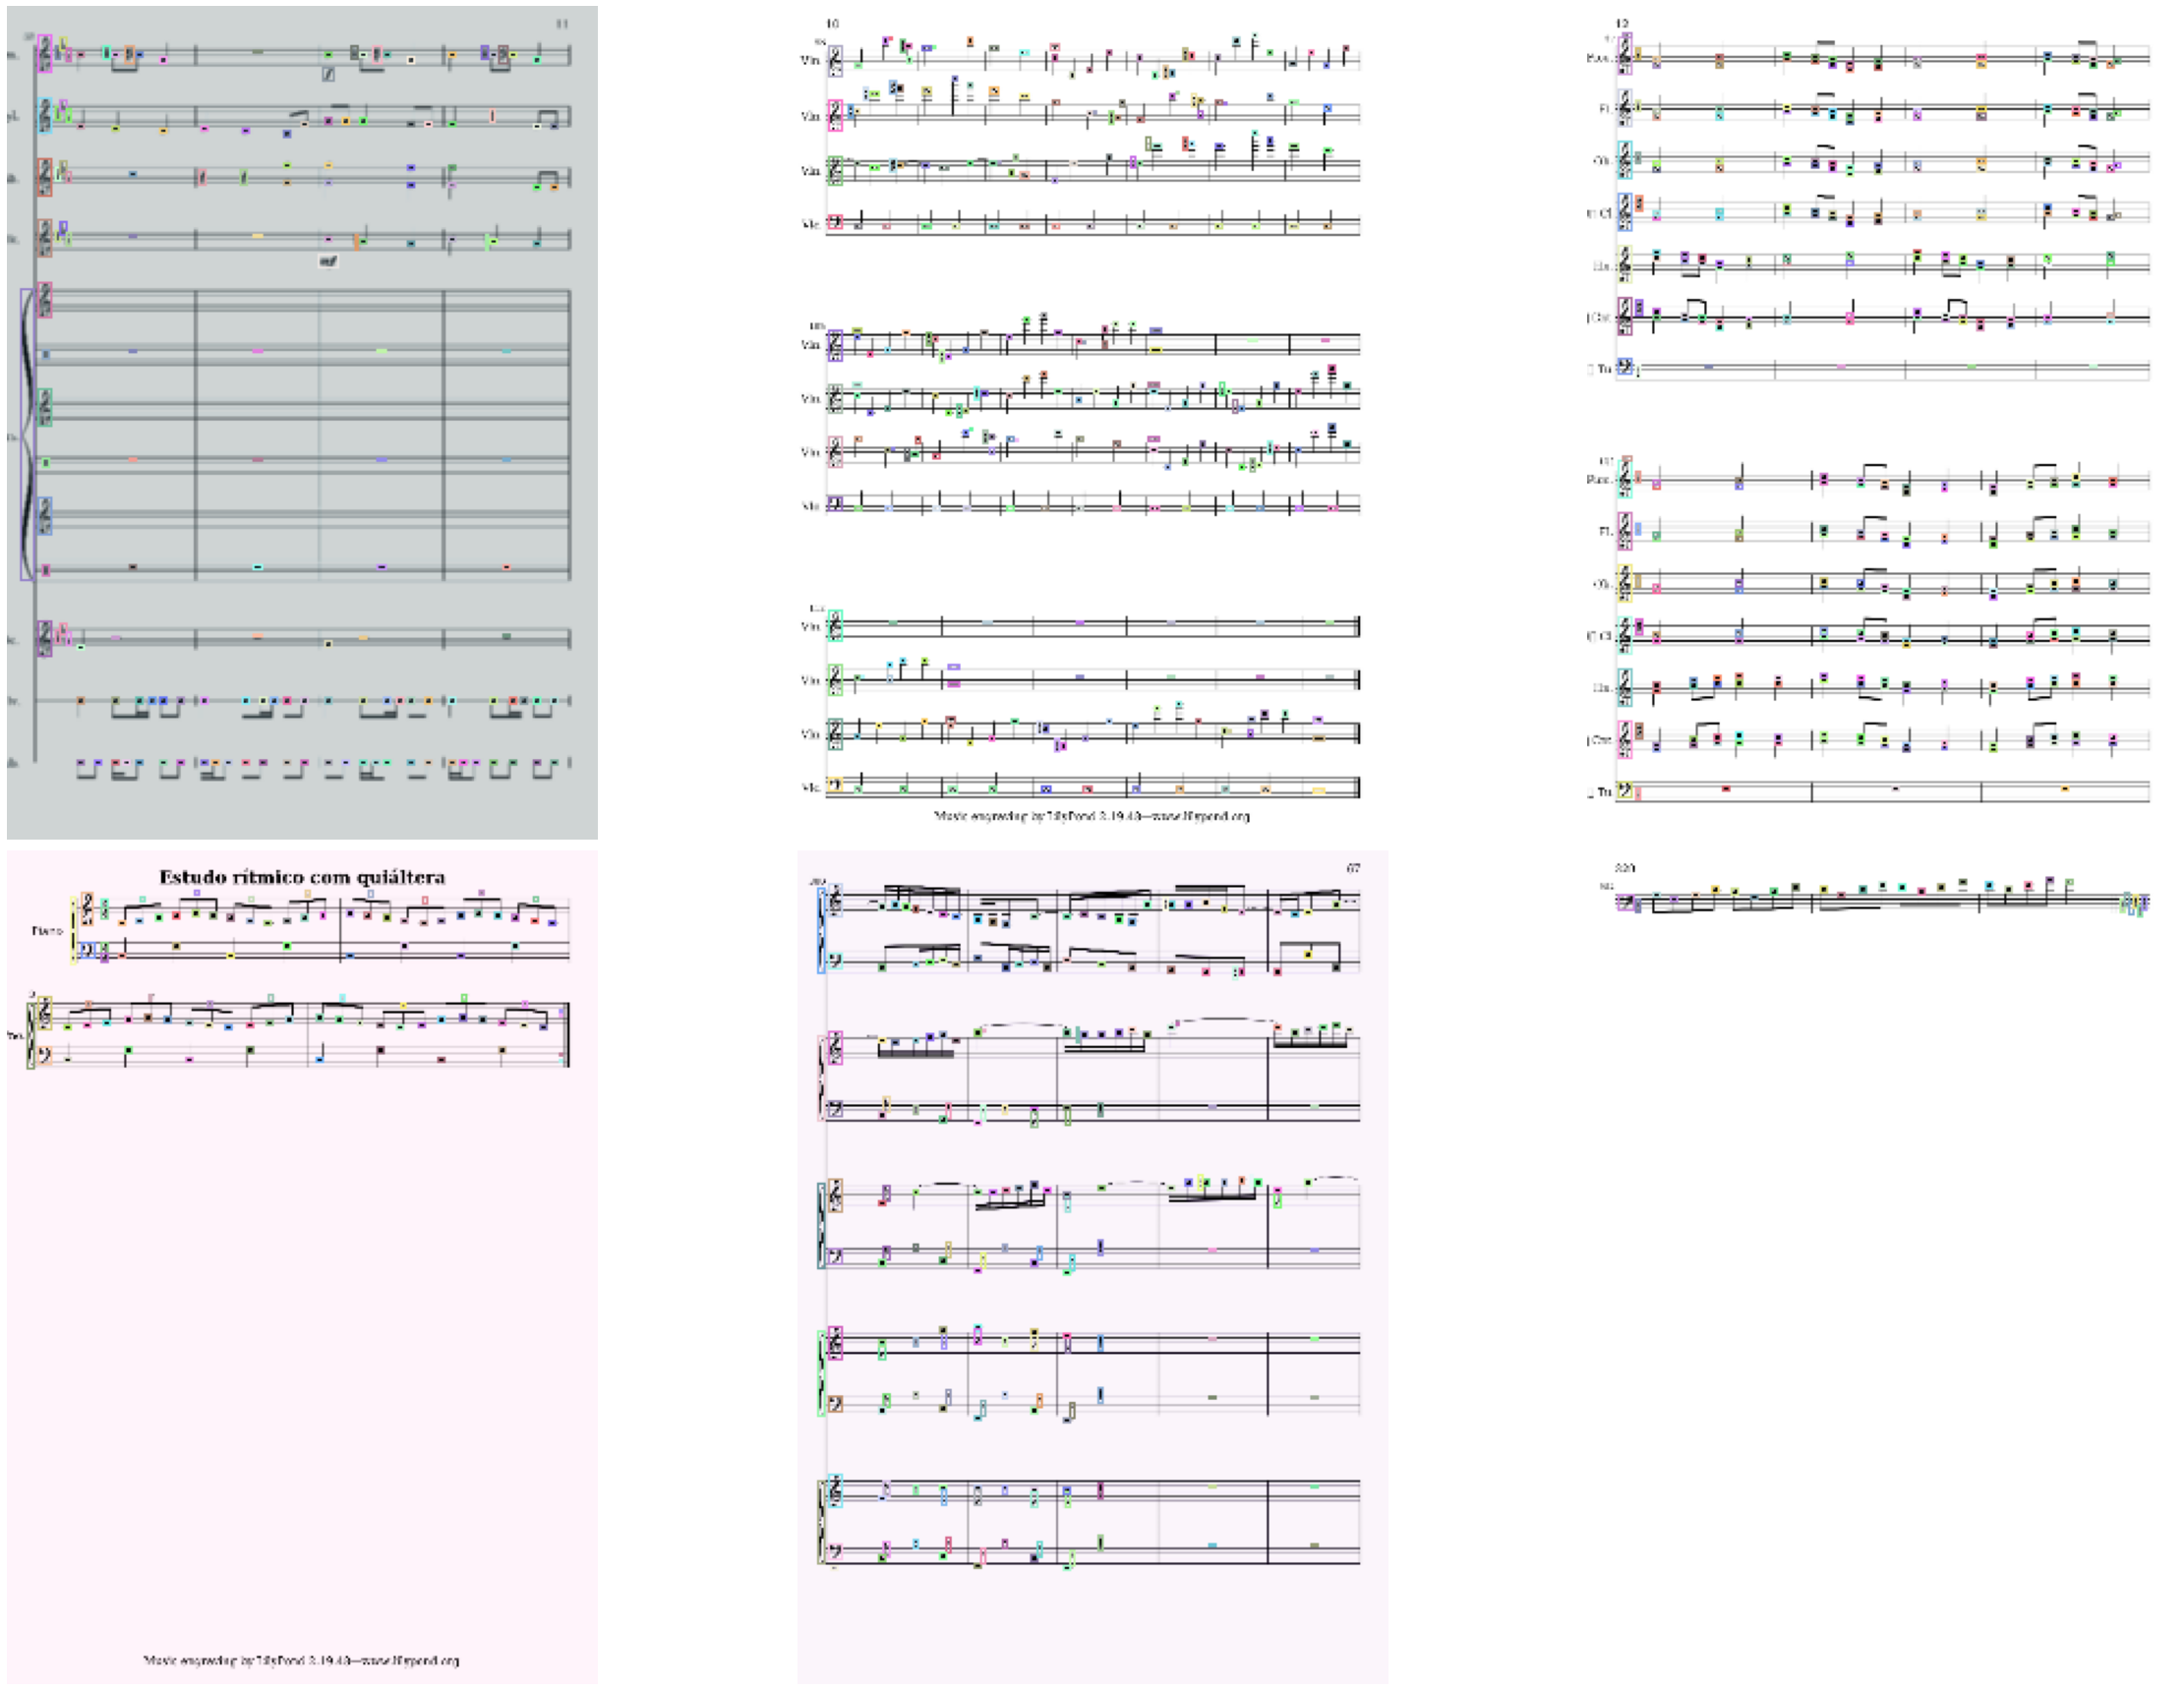

In [22]:
samples = [train_ds[i] for i in range(6)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True)

In [23]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [24]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [25]:
saveM=SaveModelMAP(monitor='COCOMetric',fname='FasterRCMM',comp=compareM)
lrReduce=ReduceLRMAP(monitor='COCOMetric',patience=3, factor=10.0, min_lr=0,comp=compareM)
early=EarlyStoppingMAP(monitor='COCOMetric',patience=5,comp=compareM)

In [26]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=[saveM,lrReduce,early])

In [27]:
print(learn.recorder.metrics)
(min_lr,step)=learn.lr_find(show_plot=False)

In [ ]:
learn.fine_tune(150, lr_min=min_lr, lr_step=step, freeze_epoch=2)